In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Non-stationary Bandits

### In a stochastic non-stationary environment, the mean of the distributions from which rewards are sampled __changes__ over time. Thus, to define a non-stationary environment for K-armed bandit problem, we need a set a functions that describe the evolution of the average rewards.

### **NOTE**: we will only deal with piecewise-constant functions to describe the evolution of average rewards, since they are easier to deal with

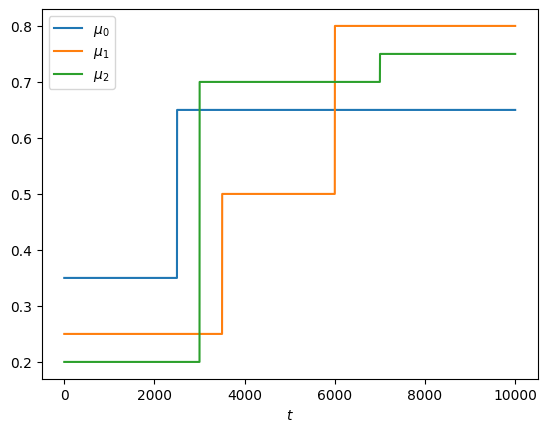

In [2]:
T = 10000
K = 3

# we need to define multiple sequences of rewards and be able to access them comfortably
mu = ([0.35]*2500 + [0.65]*7500,
        [0.25]*3500 + [0.5]*2500 + [0.8]*4000,
        [0.2]*3000 + [0.7]*4000 + [0.75]*3000
    )
# we define a function that goes from [1,...,T] -> [0,1]^3
# it is a good practice to keep rewards (or at least their average) in [0,1] also in non-stationary environments
t = np.arange(T)
plt.plot(t, np.c_[mu], label=[f'$\mu_{i}$' for i in range(K)])
plt.legend()
plt.xlabel('$t$')
plt.show();

#### Note: the functions doesn't need to be non-decreasing, they can vary arbitrarily (even decrease). FYI, non-stationary bandits where average rewards never decrease are called _rising_ bandits. On the contrary, if average rewards never increase we refer to them as _rotting_ bandits. Those are easier class of problems where ad-hoc algorithms can be used to obtain better performances.

### As the time passes, the average rewards change their means. Imagine to face this bandit problem as an adversarial one: what would be the best policy?

Cumulative rewards for every arm: [5750. 5325. 5650.]
Best arm in hindsight: 0


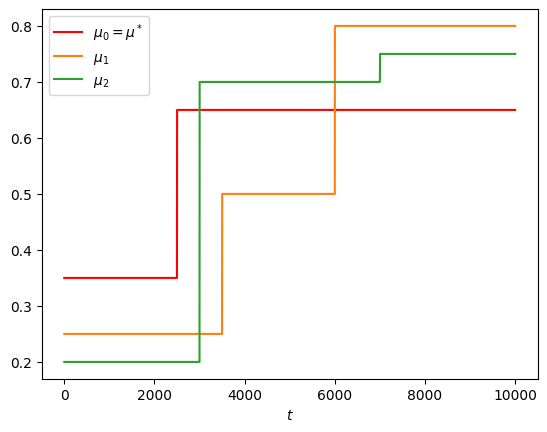

In [15]:
# Best-arm in Hindsight:
cum_rew = np.array(mu).sum(axis=1)
best_arm = np.argmax(cum_rew)
print(f'Cumulative rewards for every arm: {cum_rew}')
print(f'Best arm in hindsight: {best_arm}')

for i in range(K):
    if i == best_arm:
        plt.plot(t, mu[i], label=f'$\mu_{i} = \mu^*$', c='red')
    else:
        plt.plot(t, mu[i], label=f'$\mu_{i}$', c=f'C{i}')

plt.legend()
plt.xlabel('$t$')
plt.show();

### A no-regret adversarial learner would have its performance compared to the clairvoyant that __always__ pulls arm 2.

### In non-stationary stochastic environments, we look for a stronger notion of regret, which is the _policy regret_: the learner is compared to the best possible __policy__ in hindsight, i.e., the best possible sequence of actions.

Best possible cumulative reward: 6500.000000000514


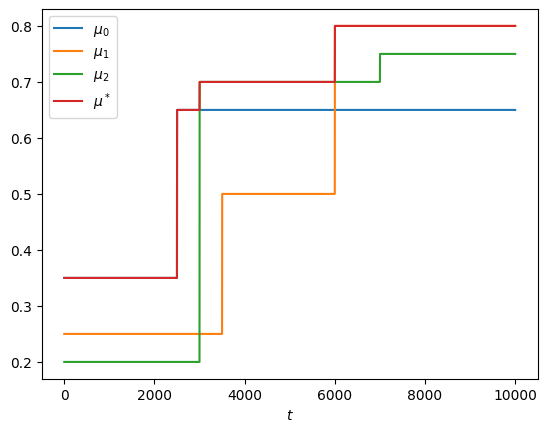

In [5]:
# Best policy in Hindsight:
best_rewards = np.array(mu).max(axis=0) # we take the max over every single round
best_cum_rew = sum(best_rewards)
best_policy = np.array(mu).argmax(axis=0)
print(f'Best possible cumulative reward: {best_cum_rew}') # is higher than the cumulative reward of the best arm in hindsight

for i in range(K):
        plt.plot(t, mu[i], label=f'$\mu_{i}$')
plt.plot(t, best_rewards, label=f'$\mu^*$')

plt.legend()
plt.xlabel('$t$')
plt.show();

### Note that 
### $$ \underbrace{\max_{a} \sum_{t=1}^T \mu_a(t)}_{\text{best arm in hindsight cumulative reward (adversarial clairvoyant)}} \le \underbrace{\sum_{t=1}^T \max_a \mu_a(t)}_{\text{best policy cumulative reward (non-stationary stochastic clairvoyant)}},$$
### where $=$ holds if there's an arm dominating all the other in every single round.

## Non-Stationary Stochastic Environment

### Note: it makes no sense to talk of Non-Stationary _Adversarial_ environment, every Non-Stationary Stochastic environment is also an adversarial environment, what changes is the way to evaluate a learner's performance

### If the average reward functions are in [0,1], we can use them as the probability of success in sampling from a Bernoulli

In [12]:
# similar implementation of the stationary scenario
class NonstationaryBernoulliEnvironment:
    def __init__(self, mu, T, seed):
        np.random.seed(seed)
        self.mu = np.array(mu)
        self.rewards = np.random.binomial(n=1, p=self.mu.T)
        self.K = self.rewards.shape[1]
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

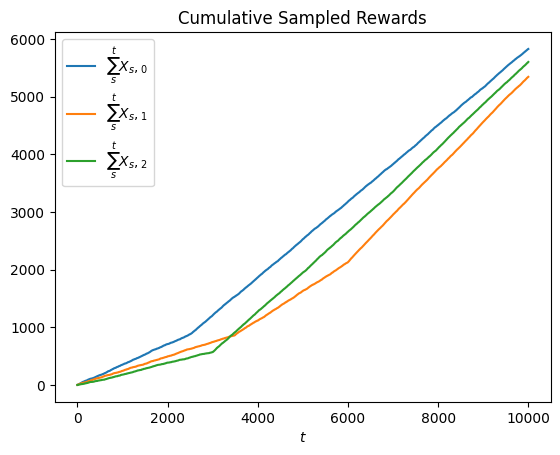

In [13]:
env = NonstationaryBernoulliEnvironment(mu, T, seed=17)
y = env.rewards
plt.plot(t, env.rewards.cumsum(axis=0), label=[f'$\sum_s^t X_s,_{i}$' for i in range(K)])
plt.legend()
plt.xlabel('$t$')
plt.title('Cumulative Sampled Rewards')
plt.show();

### How do we expect UCB1 to perform on this environment?

In [16]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Same code from Lab 1:

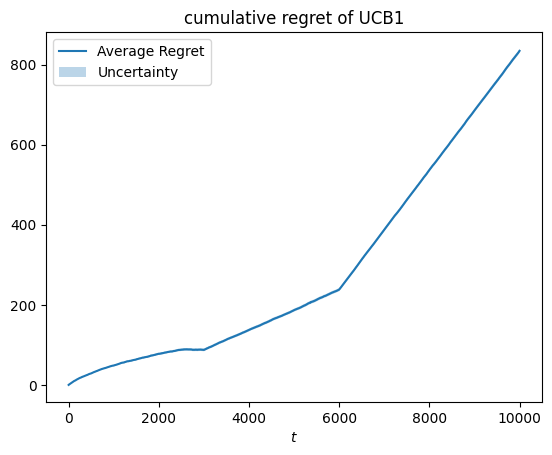

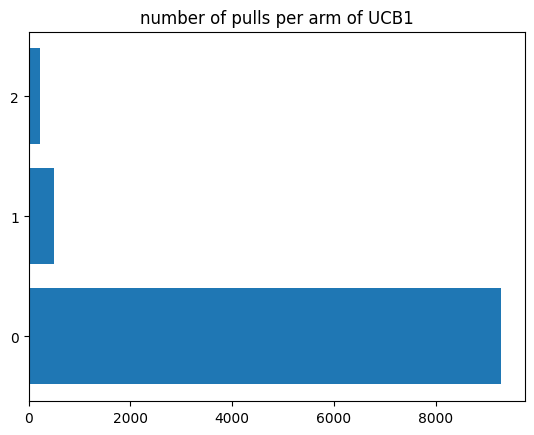

In [19]:
T = 10000
n_epochs = 20
mu = ([0.35]*2500 + [0.65]*7500,
        [0.25]*3500 + [0.5]*2500 + [0.8]*4000,
        [0.2]*3000 + [0.7]*4000 + [0.75]*3000
    )
x = np.arange(T)
K = len(y)

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')
plt.show();

### Why the regret has a convex shape? -> very important question

## Sliding Window Strategies - SW-UCB

### Idea: try to adapt to environment's changes by only considering most recent rewards

In [126]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

### How to choose $W$ according to theory:
### $$ W = \left \lfloor 2B\sqrt{T \log T / \Upsilon_T} \right \rfloor,$$
### where $B$ is the maximum reward ($B=1$ for Bernoulli), and $\Upsilon_T$ is the maximum number of times an arm changes its average reward. 
### Reference: https://arxiv.org/pdf/0805.3415 (Remark 9)
### **NOTE**: this choice only works for environments with abrupt changes, to work on smoothly changing environments some modifications to the algorithm are needed

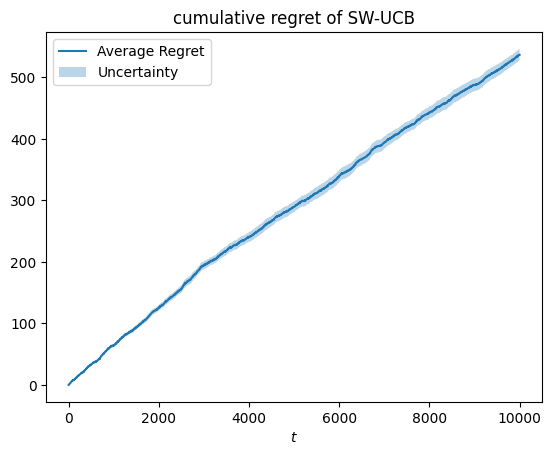

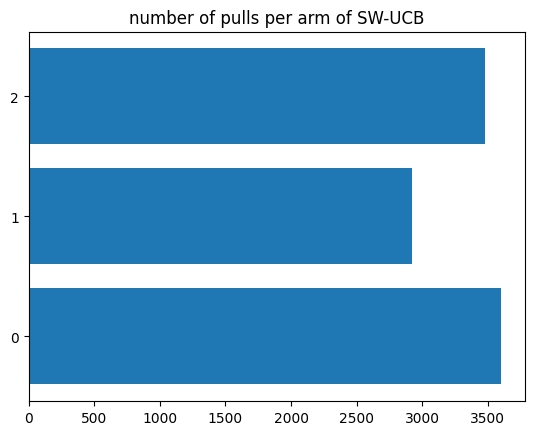

In [127]:
T = 10000
n_epochs = 20
mu = ([0.35]*2500 + [0.65]*7500,
        [0.25]*3500 + [0.5]*2500 + [0.8]*4000,
        [0.2]*3000 + [0.7]*4000 + [0.75]*3000
    )
K = len(mu)
U_T = 3 # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U_T)) # assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of SW-UCB')
plt.show();

### Sublinear regret!

### Exercise: code Sliding Window Thompson Sampling and compare its performances with SW-UCB and UCB1 on this environment

### Reference fon SW-TS: https://www.jair.org/index.php/jair/article/view/11407/26587 (Algorithm 1)

### Hint: set $W$ as $\sqrt{T}$ it the number of breakpoints is negligible w.r.t. to $T$ (i.e., $\Upsilon_T << T$)

## Change Detection Approaches - CUSUM-UCB

### Idea: play with an algorithm for stationary environments (e.g., UCB1) until you detect a change in the average reward of a specific arm, then reset the algorithm's knowledge on that arm.

### Reference: https://arxiv.org/pdf/1711.03539 (Algorithm 3)

In [106]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0
    
    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                self.n_resets[self.a_t] +=1 
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t 
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False


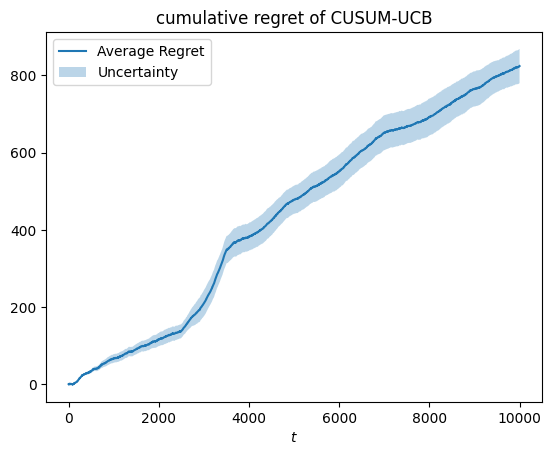

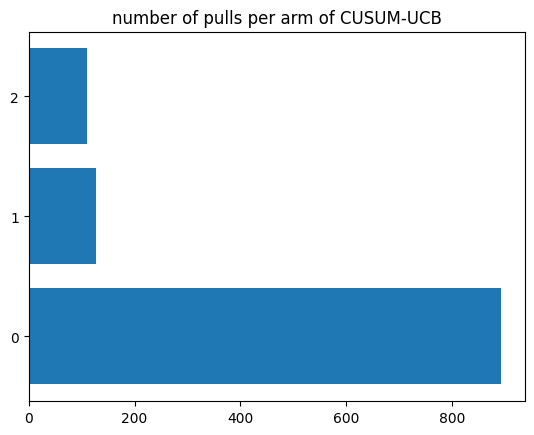

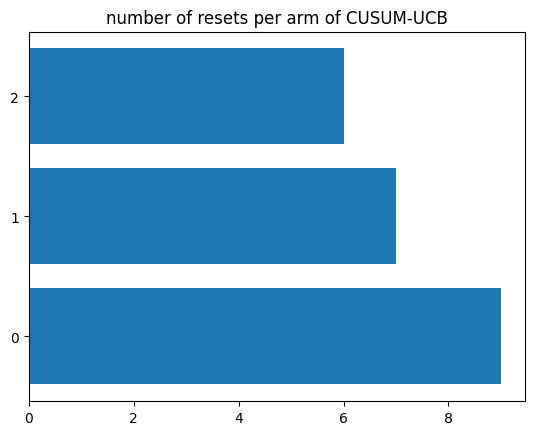

In [120]:
T = 10000
n_epochs = 20
mu = ([0.35]*2500 + [0.65]*7500,
        [0.25]*3500 + [0.5]*2500 + [0.8]*4000,
        [0.2]*3000 + [0.7]*4000 + [0.75]*3000
    )
K = len(mu)
U_T = 3 # maximum number of abrupt changes
h = 2*np.log(T/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(T/U_T)/T) # probability of extra exploration

M = int(np.log(T/U_T)) # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of CUSUM-UCB')
plt.show();

plt.barh(y=['0','1','2'], width=ucb_agent.n_resets)
plt.title('number of resets per arm of CUSUM-UCB')
plt.show();

### CUSUM-UCB achieves comparable performances w.r.t. SW-UCB in this scenario. However there are several drawbacks:
### - more hyper-parameters
### - additional assumptions (see paper)
### - heavier computational burden

## Concluding Remarks: 
###   1. In environments with abrupt changes, regret usually scales with the maximum number of changes in an arm $\Upsilon_T$
###   2. The prior knowledge on $\Upsilon_T$ may improve algorithms' performances, since it can be used to set hyper-parameters sharply
###   3. In online learning there is really no "tuning", since we cannot evaluate different hyper-parameters on the same trial (which is assumed to be a "one-shot" trial). Thus, hyper-parameters choice is only driven by theory and by an eventual prior knowledge on the environment (i.e., $\Upsilon_T$)
###   4. In smoothly changing environments the role of $\Upsilon_T$ is usually replaced by $V_T$, which is the maximum total variation in the average reward of an arm. Some algorithms can be easily used in both abrupt changes and smooth changes scenarios (such as SW-UCB, with some modifications), while others, such as CUSUM-UCB, are not